# 2.1.3. Bài tập thực hành 1: Xây dựng cây quyết định và rừng cây với dữ liệu Titanic

**Mô tả bài toán:** Sử dụng dataset Titanic từ Kaggle (train.csv và test.csv) để xây dựng mô hình phân loại dự đoán hành khách có sống sót (Survived) hay không.

- **train.csv**: Dữ liệu huấn luyện (có nhãn Survived).
- **test.csv**: Dữ liệu kiểm tra (không có nhãn, cần predict).
- **gender_submission.csv**: File mẫu submission.

**Nhiệm vụ chính:**
1. Tiền xử lý dữ liệu (xử lý missing values, encode categorical features).
2. Xây dựng và đánh giá Decision Tree.
3. Xây dựng và đánh giá Random Forest.
4. Tối ưu hóa hyperparameters bằng GridSearchCV.
5. Visualize cây quyết định và feature importance.
6. Predict trên test.csv và lưu submission.csv.

**Lưu ý:** Giả sử các file CSV đã được tải về thư mục làm việc. Nếu chưa, tải từ https://www.kaggle.com/c/titanic/data.

In [1]:
# 1. Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400  # High res figures
import graphviz  # Để visualize decision trees (cài đặt: pip install graphviz)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns  # Để EDA (tùy chọn)

print("Libraries imported successfully.")

Libraries imported successfully.


In [3]:
# 2. Load dữ liệu train.csv và xem cấu trúc
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain columns:", train_df.columns.tolist())
print("\nTrain head:\n", train_df.head())

# EDA ngắn gọn: Kiểm tra missing values
print("\nMissing values in train:")
print(train_df.isnull().sum())

Train shape: (891, 12)
Test shape: (418, 11)

Train columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Train head:
    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 1

In [5]:
# 3. Tiền xử lý dữ liệu
# Chọn features hữu ích: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked
# Bỏ: PassengerId, Name, Ticket, Cabin (quá nhiều missing)

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X_train_full = train_df[features].copy()
y_train_full = train_df['Survived']
X_test = test_df[features].copy()

# Xử lý missing values
# Age: Impute bằng median
imputer_age = SimpleImputer(strategy='median')
X_train_full['Age'] = imputer_age.fit_transform(X_train_full[['Age']])
X_test['Age'] = imputer_age.transform(X_test[['Age']])

# Fare: Impute bằng median (test có 1 missing)
imputer_fare = SimpleImputer(strategy='median')
# Check for missing Fare in test_df before imputing
if X_test['Fare'].isnull().sum() > 0:
    X_test['Fare'] = imputer_fare.fit_transform(X_test[['Fare']])

# Embarked: Impute bằng mode (train có 2 missing)
imputer_emb = SimpleImputer(strategy='most_frequent')
X_train_full['Embarked'] = imputer_emb.fit_transform(X_train_full[['Embarked']]).ravel() # Use ravel() to flatten to 1D array
X_test['Embarked'] = imputer_emb.transform(X_test[['Embarked']]).ravel() # Use ravel() to flatten to 1D array

# Ensure Embarked column has a consistent dtype after imputation
X_train_full['Embarked'] = X_train_full['Embarked'].astype(str)
X_test['Embarked'] = X_test['Embarked'].astype(str)


# Encode categorical: Sex và Embarked
le_sex = LabelEncoder()
X_train_full['Sex'] = le_sex.fit_transform(X_train_full['Sex'])
X_test['Sex'] = le_sex.transform(X_test['Sex'])

# Before encoding Embarked, check unique values to ensure consistency
# print("Unique values in X_train_full['Embarked'] before encoding:", X_train_full['Embarked'].unique())
# print("Unique values in X_test['Embarked'] before encoding:", X_test['Embarked'].unique())

le_emb = LabelEncoder()
# Fit on the combined unique values to handle all possible categories
all_embarked = pd.concat([X_train_full['Embarked'], X_test['Embarked']]).unique()
le_emb.fit(all_embarked)

X_train_full['Embarked'] = le_emb.transform(X_train_full['Embarked'])
X_test['Embarked'] = le_emb.transform(X_test['Embarked'])

# Split train thành train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print("Preprocessing done.")
print("X_train shape:", X_train.shape)
print("Features:", X_train.columns.tolist())

Preprocessing done.
X_train shape: (712, 7)
Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


## Nhiệm vụ 1: Xây dựng và Visualize Decision Tree

In [6]:
# 4. Xây dựng Decision Tree cơ bản (max_depth=3 để visualize dễ)
dt = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# Predict trên validation
y_pred_dt = dt.predict(X_val)
acc_dt = accuracy_score(y_val, y_pred_dt)
print(f"Decision Tree Accuracy: {acc_dt:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_dt))

Decision Tree Accuracy: 0.7989

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



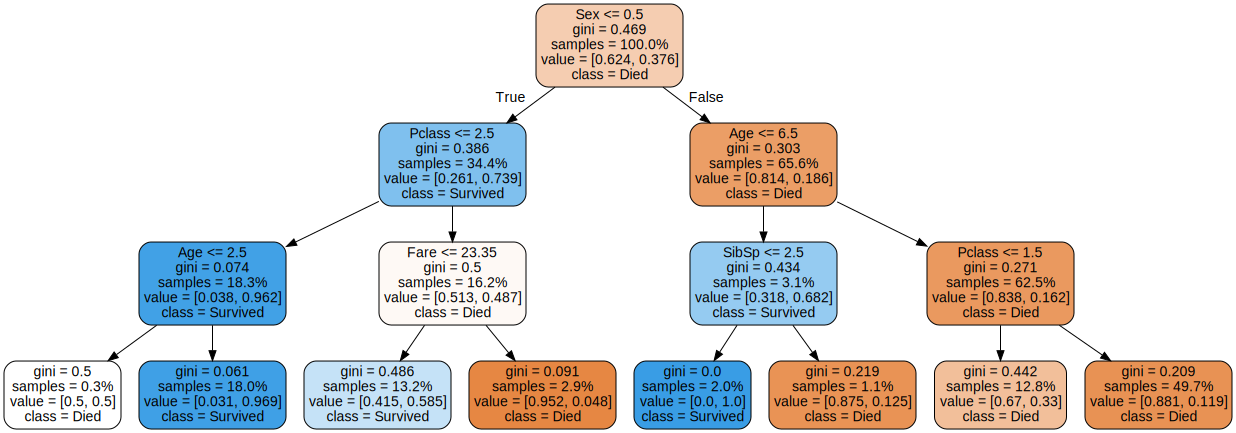

In [7]:
# 5. Visualize cây quyết định
feature_names = X_train.columns.tolist()
dot_data = tree.export_graphviz(dt,
                                out_file=None,
                                filled=True,
                                rounded=True,
                                feature_names=feature_names,
                                proportion=True,
                                class_names=['Died', 'Survived'])
graph = graphviz.Source(dot_data)
graph

## Nhiệm vụ 2: Tối ưu hóa Decision Tree bằng GridSearchCV

In [8]:
# 6. GridSearchCV cho max_depth
params_dt = {'max_depth': [2, 3, 4, 5, 6, 7, 8]}
dt_grid = tree.DecisionTreeClassifier(random_state=42)
cv_dt = GridSearchCV(dt_grid, param_grid=params_dt, scoring='accuracy',
                     cv=5, verbose=1, n_jobs=-1, return_train_score=True)
cv_dt.fit(X_train, y_train)

print("Best params for DT:", cv_dt.best_params_)
print("Best CV score:", cv_dt.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best params for DT: {'max_depth': 3}
Best CV score: 0.8202107751403526


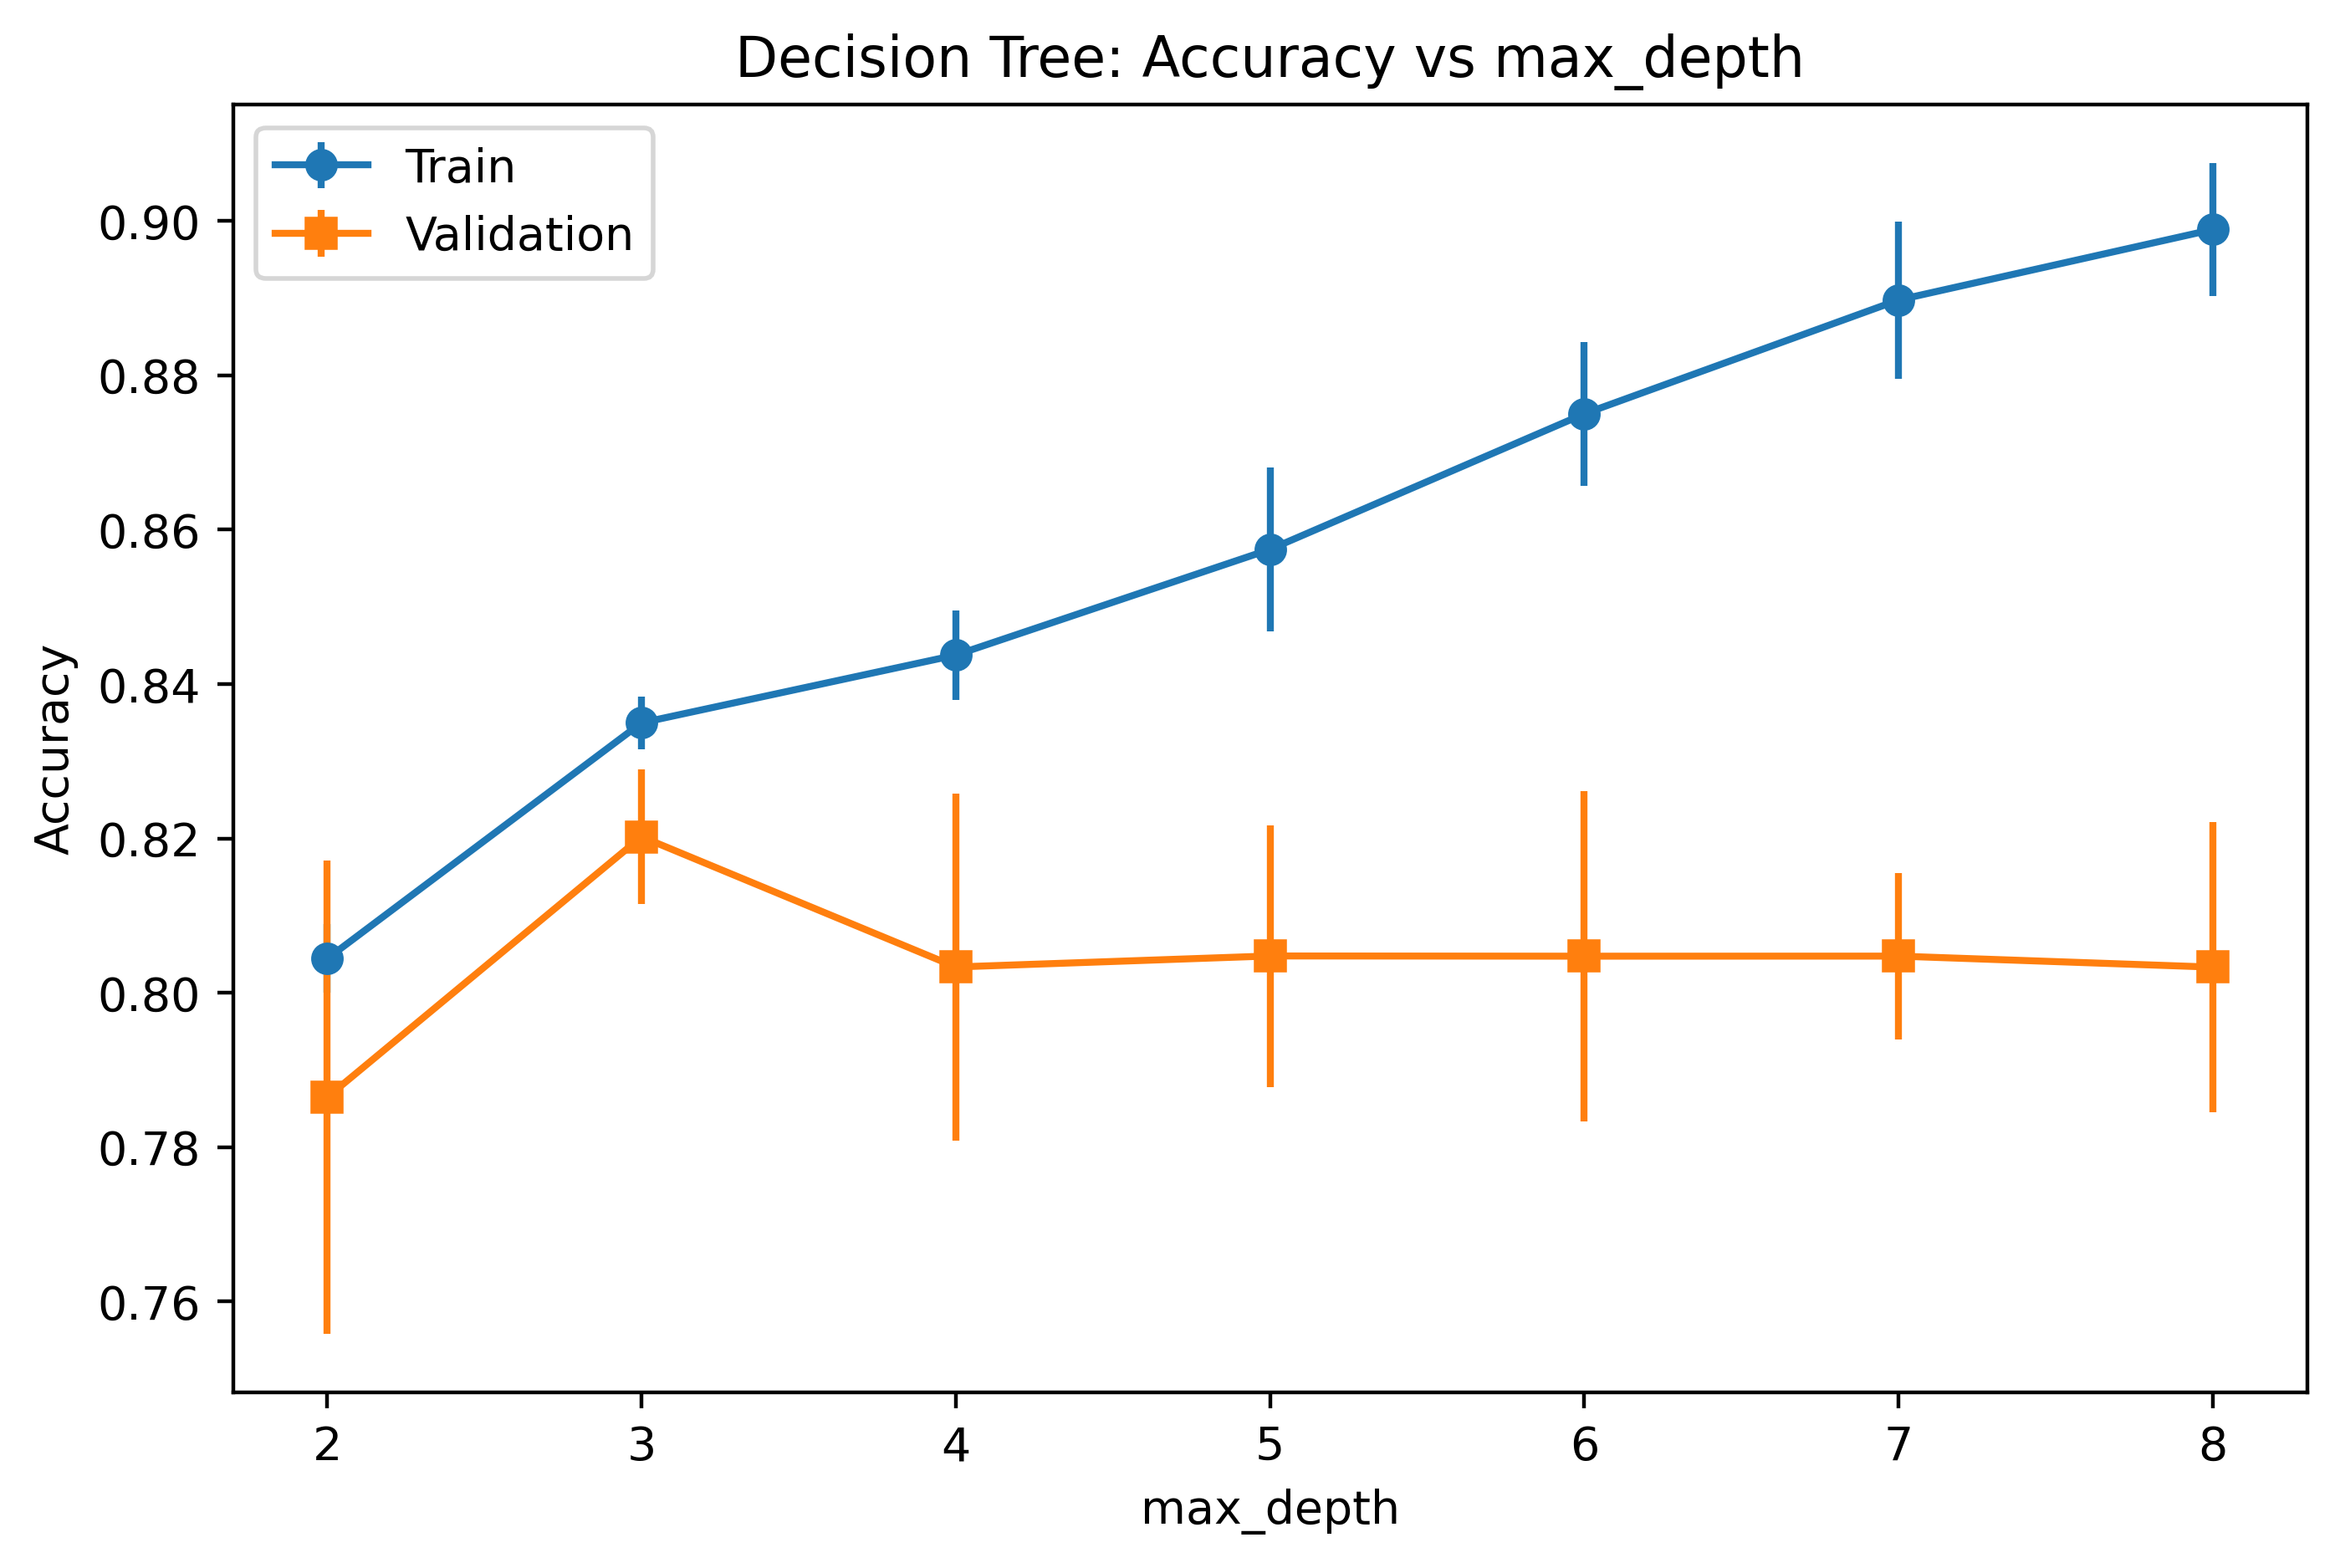

In [9]:
# 7. Vẽ biểu đồ đánh giá theo max_depth
cv_results_df = pd.DataFrame(cv_dt.cv_results_)
plt.figure(figsize=(8, 5))
plt.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_train_score'],
             yerr=cv_results_df['std_train_score'],
             label='Train', marker='o')
plt.errorbar(cv_results_df['param_max_depth'],
             cv_results_df['mean_test_score'],
             yerr=cv_results_df['std_test_score'],
             label='Validation', marker='s')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Decision Tree: Accuracy vs max_depth')
plt.show()

## Nhiệm vụ 3: Xây dựng và Tối ưu hóa Random Forest

In [10]:
# 8. Xây dựng Random Forest cơ bản
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict và đánh giá
y_pred_rf = rf.predict(X_val)
acc_rf = accuracy_score(y_val, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_rf))

Random Forest Accuracy: 0.8156

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.84      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



In [11]:
# 9. GridSearchCV cho n_estimators
params_rf = {'n_estimators': [10, 50, 100, 150, 200]}
rf_grid = RandomForestClassifier(max_depth=5, random_state=42)
cv_rf = GridSearchCV(rf_grid, param_grid=params_rf, scoring='accuracy',
                     cv=5, verbose=1, n_jobs=-1, return_train_score=True)
cv_rf.fit(X_train, y_train)

print("Best params for RF:", cv_rf.best_params_)
print("Best CV score:", cv_rf.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params for RF: {'n_estimators': 150}
Best CV score: 0.8314094356347876


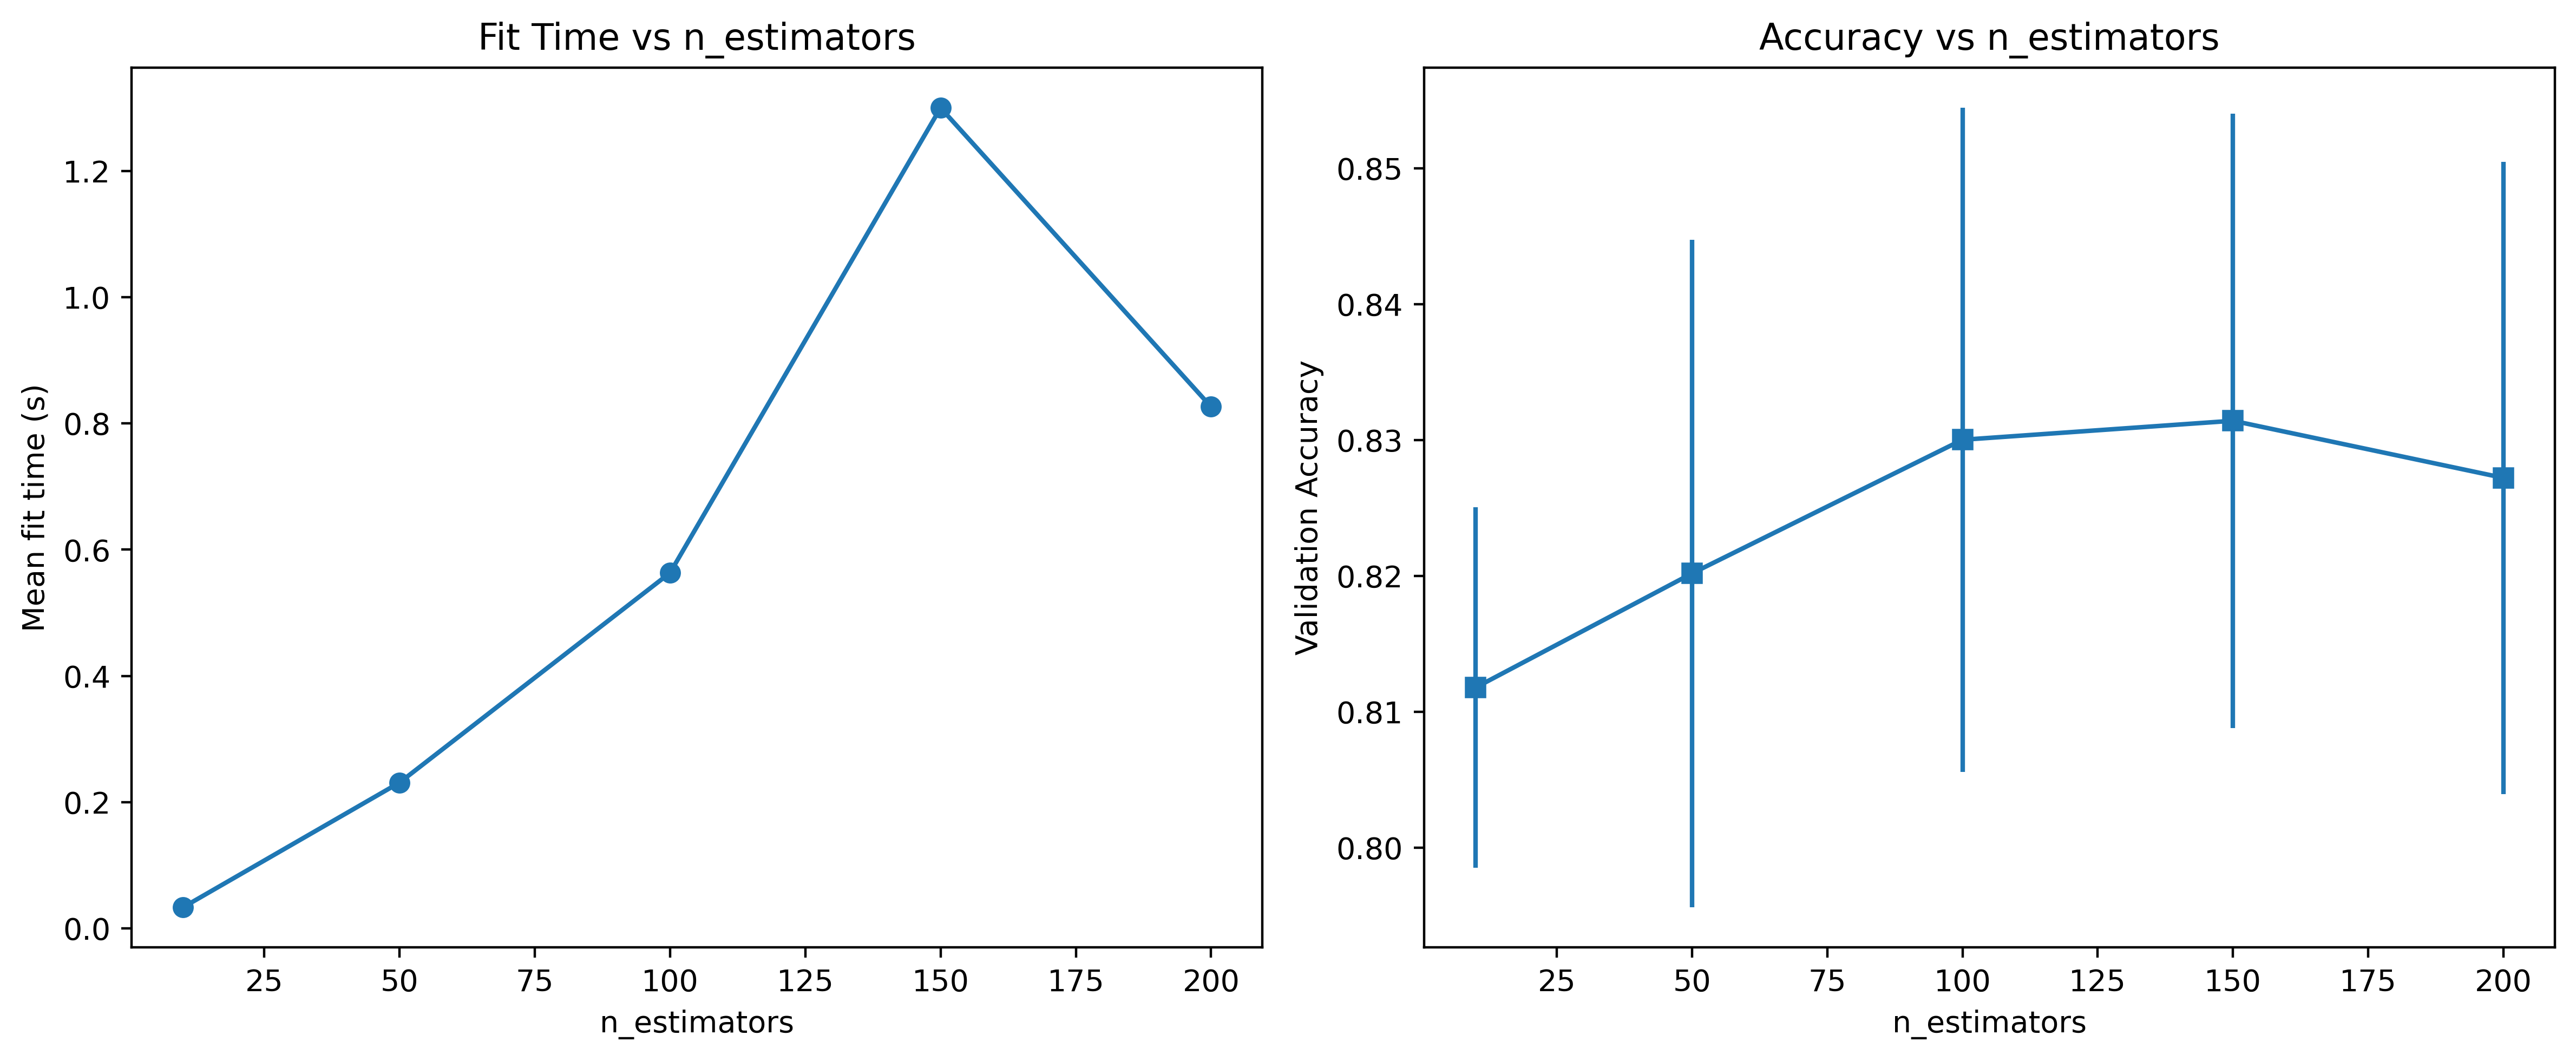

In [12]:
# 10. Vẽ biểu đồ đánh giá theo n_estimators
cv_rf_results_df = pd.DataFrame(cv_rf.cv_results_)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Fit time
ax1.plot(cv_rf_results_df['param_n_estimators'], cv_rf_results_df['mean_fit_time'], 'o-')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Mean fit time (s)')
ax1.set_title('Fit Time vs n_estimators')

# Accuracy
ax2.errorbar(cv_rf_results_df['param_n_estimators'],
             cv_rf_results_df['mean_test_score'],
             yerr=cv_rf_results_df['std_test_score'], marker='s')
ax2.set_xlabel('n_estimators')
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Accuracy vs n_estimators')

plt.tight_layout()
plt.show()

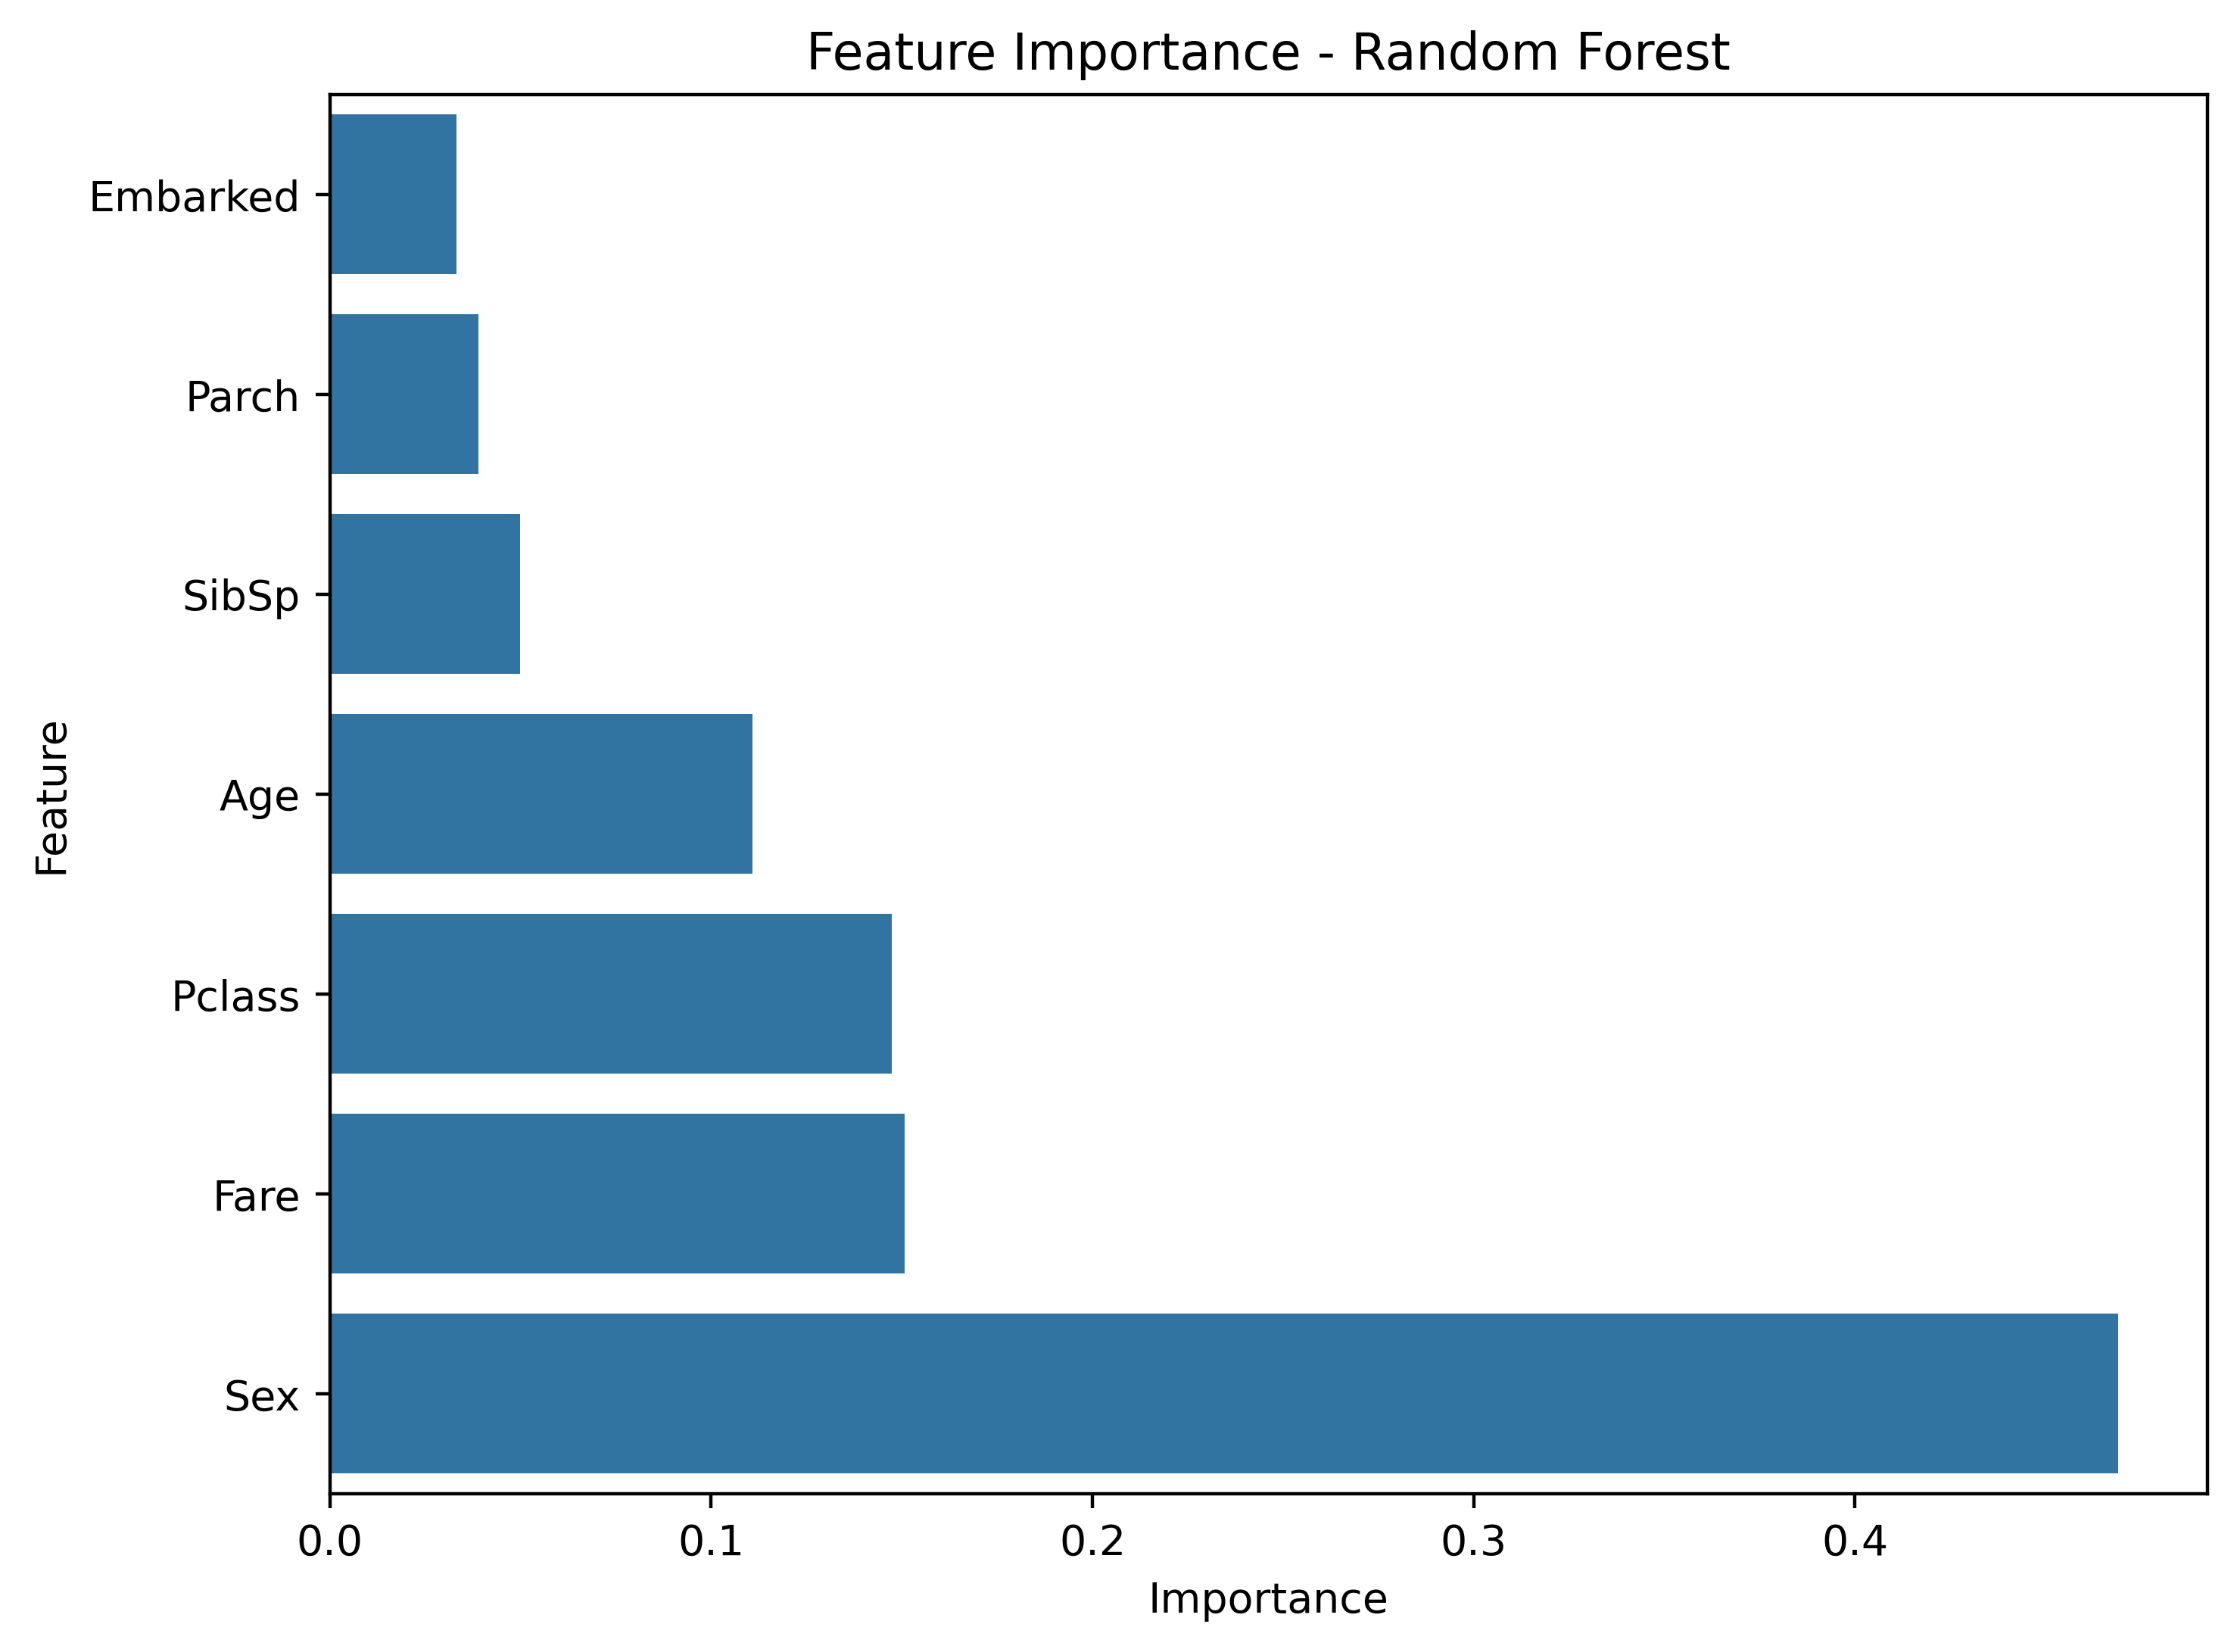

    Feature  Importance
6  Embarked    0.033257
4     Parch    0.038994
3     SibSp    0.049817
2       Age    0.110809
0    Pclass    0.147373
5      Fare    0.150855
1       Sex    0.468895


In [13]:
# 11. Feature Importance từ Random Forest tốt nhất
best_rf = cv_rf.best_estimator_
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp, x='Importance', y='Feature')
plt.title('Feature Importance - Random Forest')
plt.show()
print(feat_imp)

## Nhiệm vụ 4: Predict trên test.csv và lưu submission

In [14]:
# 12. Train model tốt nhất trên full train data
best_rf_full = RandomForestClassifier(n_estimators=cv_rf.best_params_['n_estimators'],
                                      max_depth=5, random_state=42)
best_rf_full.fit(X_train_full, y_train_full)

# Predict trên test
test_predictions = best_rf_full.predict(X_test)

# Tạo submission file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission saved as 'submission.csv'.")
print("\nFirst 10 predictions:")
print(submission.head(10))

Submission saved as 'submission.csv'.

First 10 predictions:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0
